In [1]:
%load_ext autoreload
%autoreload 2


import os

from math import ceil, floor

import copy

import pickle

import numpy as np

from matplotlib import pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets.vision import VisionDataset

from tqdm import tqdm

from datasets import prepare_poison_dataset
from simclr import SimClrBackbone

from util import *

## Poison reclassification

### Weak binary classifier 

In [16]:
class PoisonClassificationDataset(VisionDataset):

    def __init__(self, original_dataset: VisionDataset, poison_indices: np.array) -> None:
        self.original_dataset = original_dataset
        self.poison_indices = poison_indices

    def __len__(self) -> int:
        return len(self.original_dataset)
    
    def __getitem__(self, index: int):
        return self.original_dataset[index][0], torch.tensor(self.poison_indices[index])

In [17]:
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        out = F.sigmoid(out)
        return out


def ResNetBinary():
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=1)

In [18]:
import torch.nn as nn
from torch.utils.data import WeightedRandomSampler

class ConvolutionalBinaryClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2, bias=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2, bias=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Flatten(),
            nn.Linear(1568, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x) -> torch.tensor:
        return self.layers(x)

def train_binary_classifier(dataset: VisionDataset, predicted_poison_indices: np.array) -> nn.Module:
    poison_classification_dataset = PoisonClassificationDataset(dataset, predicted_poison_indices)
    # sampler for class imbalance
    positives = sum([1 for _, target in poison_classification_dataset if target==1])
    total = len(poison_classification_dataset)
    positive_weight = 0.5 / positives
    negative_weight = 0.5 / (total - positives)
    weights = [positive_weight if target==1 else negative_weight for _, target in poison_classification_dataset]
    sampler = WeightedRandomSampler(weights, len(weights))

    dataloader = DataLoader(poison_classification_dataset, batch_size=128, sampler=sampler)
    model = ResNetBinary().to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1-1e-4)
    num_epochs = 10

    for _ in tqdm(range(num_epochs)):
        for _, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(device), targets.to(device).float()
            optimizer.zero_grad()
            logits = model.forward(inputs).squeeze(-1)
            loss = criterion(logits, targets)
            loss.backward()
            optimizer.step()
        scheduler.step()

    return model

def binary_reclassification(dataset: VisionDataset, model: nn.Module):
    predicted_poison_indices = np.zeros((len(dataset)))
    batch_size = 128
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    for i, (inputs, _, _) in enumerate(dataloader):
        inputs = inputs.to(device)
        with torch.no_grad():
            logits = model.forward(inputs).squeeze(-1)
            predictions = (logits>0.5).cpu().numpy()
        predicted_poison_indices[i*batch_size : i*batch_size+len(predictions)] = predictions
    return predicted_poison_indices==1
        


### Strong multiclass classifier

In [19]:
from torchvision import transforms

class CleansedDataset(VisionDataset):

    def __init__(self, poison_dataset: VisionDataset, predicted_poison: np.array, transforms: torch.nn.Module = None):
        self.data = [poison_dataset[i][0] for i in range(len(poison_dataset)) if not predicted_poison[i]]
        self.labels = [poison_dataset[i][1] for i in range(len(poison_dataset)) if not predicted_poison[i]]
        self.transforms = transforms

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data[index]
        label = self.labels[index]

        if self.transforms:
            item = self.transforms(item)

        return item, label

In [20]:
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [21]:
def train_multiclass_classifier(dataset: VisionDataset, predicted_poison_indices: np.array) -> nn.Module:
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    cleansed_dataset = CleansedDataset(dataset, predicted_poison_indices, transform_train)
    dataloader = DataLoader(cleansed_dataset, batch_size=128, shuffle=True, num_workers=0)

    model = ResNet18()
    model.to(device)

    epochs = 35
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

    model.train()
    for epoch in tqdm(range(epochs)):
        train_loss = 0
        correct = 0
        total = 0
        for _, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        acc = 100.*correct/total
        scheduler.step()
        print(epoch, train_loss, acc)
    model.eval()
    return model

In [22]:
def multiclass_reclassification(dataset: VisionDataset, model: nn.Module, true_labels: np.array):
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    
    transform_dataset = CleansedDataset(dataset, np.zeros(len(dataset)), transform_train)
    
    predicted_labels = np.zeros((len(dataset)))
    batch_size = 128
    dataloader = DataLoader(transform_dataset, batch_size=batch_size, shuffle=False)
    for i, (inputs, _) in enumerate(dataloader):
        inputs = inputs.to(device)
        with torch.no_grad():
            logits = model.forward(inputs)
            predictions = torch.argmax(logits, 1).cpu().numpy()
        predicted_labels[i*batch_size : i*batch_size+len(predictions)] = predictions
    return predicted_labels!=true_labels

# Final cleanse pipeline

In [39]:
dataset_name = "sig-2"
train = True

simclr_model_name = f"{dataset_name}-SimCLR.pt"

dataset, true_poison_indices, _, _ = prepare_poison_dataset(dataset_name, train)
simclr, epochs = load_simclr(simclr_model_name)
features, labels_poison, labels_true = extract_simclr_features(simclr, dataset, layer="repr")
num_classes = int(max(labels_poison).item())

print(f"SimCLR epochs = {epochs}")

c:\Users\Luka\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Luka\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SimCLR epochs = 250


In [40]:
# Hiperparameters

n_neighbors = int(len(dataset) / 500)

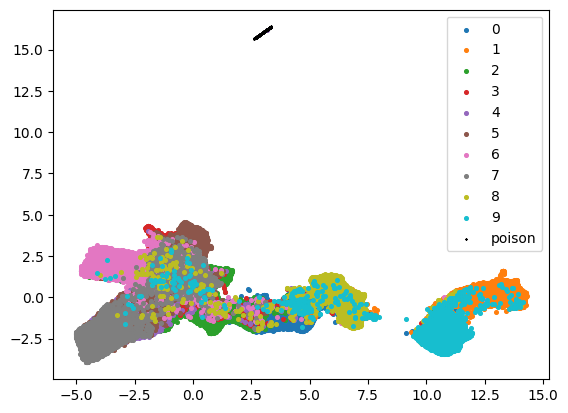

In [41]:
features_2d = calculate_features_2d(features, n_neighbors=n_neighbors)
plot_features_2d(features_2d, labels_poison, true_poison_indices, legend=True)

In [ ]:
# TESTING
# count = 0
# total = 50
# for current in range(1,total+1):
#     predicted_poison_indices_disruptive = kmeans_cleanse_smallest(features_2d, means=11)
#     pr = print_evaluate_cleanse(predicted_poison_indices_disruptive, true_poison_indices, verbose=False)
#     if pr==0:
#         count+=1
#     print(f"{pr} - {count}/{current}")

In [34]:
# Nondisruptive cleanse
predicted_poison_indices_nondisruptive = knn_cleanse(features, labels_poison, n_neighbors=n_neighbors)
print_evaluate_cleanse(predicted_poison_indices_nondisruptive, true_poison_indices)

4808 	 9624
192 	 35376
Percentage of poisoned images (out of all poisoned) kept:  3.84%
Percentage of clean images (out of all clean) kept:  78.61%
Percentage of remaining poisoned images (out of all remaining):  0.54%


In [ ]:
# Disruptive cleanse
#predicted_poison_indices_disruptive = gauss_cleanse(tsne_features, gauss_discard, poison_indices=true_poison_indices)
predicted_poison_indices_disruptive = kmeans_cleanse(features_2d, means=11, mode="both")
print_evaluate_cleanse(predicted_poison_indices_disruptive, true_poison_indices)

c:\Users\Luka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0 	 0
5000 	 45000
Percentage of poisoned images (out of all poisoned) kept:  100.00%
Percentage of clean images (out of all clean) kept:  100.00%
Percentage of remaining poisoned images (out of all remaining):  10.00%


In [ ]:
# Combine cleanses

predicted_poison_indices_final = predicted_poison_indices_nondisruptive | predicted_poison_indices_disruptive
print_evaluate_cleanse(predicted_poison_indices_final, true_poison_indices)

4942 	 8220
58 	 36780
Percentage of poisoned images (out of all poisoned) kept:  1.16%
Percentage of clean images (out of all clean) kept:  81.73%
Percentage of remaining poisoned images (out of all remaining):  0.16%


In [ ]:
#poison_multiclass_classifier_model = train_multiclass_classifier(dataset, predicted_poison_indices_final)
#poison_multiclass_classifier_model = train_binary_classifier(dataset, predicted_poison_indices_final)

In [ ]:
#predicted_poison_indices_multiclass_reclassification = multiclass_reclassification(dataset, poison_multiclass_classifier_model, labels_poison)
#predicted_poison_indices_multiclass_reclassification = binary_reclassification(dataset, poison_multiclass_classifier_model)
#print_evaluate_cleanse(predicted_poison_indices_multiclass_reclassification, true_poison_indices)

In [ ]:
# Final cleanse report
print("---------------------------------------")
train_string = "train" if train else "test"
print(f"{dataset_name} {train_string}")
print("\nNon-disruptive cleanse: ")
print_evaluate_cleanse(predicted_poison_indices_nondisruptive, true_poison_indices)
print("\nDisruptive cleanse: ")
print_evaluate_cleanse(predicted_poison_indices_disruptive, true_poison_indices)
print("\nCombined cleanse: ")
print_evaluate_cleanse(predicted_poison_indices_final, true_poison_indices)
#print("\nReclassify (multiclass) combined cleanse: ")
#print_evaluate_cleanse(predicted_poison_indices_multiclass_reclassification, true_poison_indices)
print("---------------------------------------")

---------------------------------------
badnets1 train

Non-disruptive cleanse: 
4942 	 8220
58 	 36780
Percentage of poisoned images (out of all poisoned) kept:  1.16%
Percentage of clean images (out of all clean) kept:  81.73%
Percentage of remaining poisoned images (out of all remaining):  0.16%

Disruptive cleanse: 
0 	 0
5000 	 45000
Percentage of poisoned images (out of all poisoned) kept:  100.00%
Percentage of clean images (out of all clean) kept:  100.00%
Percentage of remaining poisoned images (out of all remaining):  10.00%

Combined cleanse: 
4942 	 8220
58 	 36780
Percentage of poisoned images (out of all poisoned) kept:  1.16%
Percentage of clean images (out of all clean) kept:  81.73%
Percentage of remaining poisoned images (out of all remaining):  0.16%
---------------------------------------


In [ ]:
train_str = "train" if train else "test"
save_name = f"{dataset_name}-(knn+umap+kmeans)-{train_str}"

#save_predicted_indices(predicted_poison_indices_final, save_name)